In [15]:
import os
import re
import json
from ingredient_phrase_tagger.training import utils
from string import punctuation
import sklearn_crfsuite
from nltk.tokenize import *
import re
import json
from itertools import chain
import nltk
import pycrfsuite
import pickle as cPickle
import requests
from bs4 import BeautifulSoup
import pandas as pd
from pathlib import Path
import subprocess
import numpy as np
from googletrans import Translator




tokenizer = PunktSentenceTokenizer()

filename = 'finalized_model.pkl'
loaded_model = cPickle.load(open(filename, 'rb'))
tagger = loaded_model.tagger_

def get_ingredients_url(url):

    page = requests.get(f'{url}')
    soup = BeautifulSoup(page.content, 'html.parser')
    ingredient = ''

    for a in soup.find_all('li', class_ = "recipe-ingredients__list-item"):
        ingredient += a.get_text()+ '.'
        ingredient += '\n'

    servingsize = soup.find('p', class_ = "recipe-metadata__serving").get_text().split(' ')[1]
    recipe_title = soup.find('h1', class_ = 'gel-trafalgar content-title__text').get_text()

    try:
        servingsize = str(servingsize).split('-')[0]
    except:
        pass

    return ingredient, servingsize, recipe_title

def sent2labels(sent):
    return [word[-1] for word in sent]

def sent2features(sent):
    return [word[:-1] for word in sent]

def sent2tokens(sent):
    return [word[0] for word in sent]


def get_sentence_features(sent):
    """Gets  the features of the sentence"""
    sent_tokens = nltk.word_tokenize(utils.cleanUnicodeFractions(sent))

    sent_features = []
    for i, token in enumerate(sent_tokens):
        token_features = [token]
        token_features.extend(utils.getFeatures(token, i+1, sent_tokens))
        sent_features.append(token_features)
    return sent_features

def format_ingredient_output(tagger_output, display=False):
    """Formats the tagger output into a more convenient dictionary"""
    data = [{}]
    display = [[]]
    prevTag = None


    for token, tag in tagger_output:
    # turn B-NAME/123 back into "name"
        tag = re.sub(r'^[BI]\-', "", tag).lower()

        # ---- DISPLAY ----
        # build a structure which groups each token by its tag, so we can
        # rebuild the original display name later.

        if prevTag != tag:
            display[-1].append((tag, [token]))
            prevTag = tag
        else:
            display[-1][-1][1].append(token)
            #               ^- token
            #            ^---- tag
            #        ^-------- ingredient

            # ---- DATA ----
            # build a dict grouping tokens by their tag

            # initialize this attribute if this is the first token of its kind
        if tag not in data[-1]:
            data[-1][tag] = []

        # HACK: If this token is a unit, singularize it so Scoop accepts it.
        if tag == "unit":
            token = utils.singularize(token)

        data[-1][tag].append(token)

    # reassemble the output into a list of dicts.
    output = [
        dict([(k, utils.smartJoin(tokens)) for k, tokens in ingredient.items()])
        for ingredient in data
        if len(ingredient)
    ]

    # Add the raw ingredient phrase
    for i, v in enumerate(output):
        output[i]["input"] = utils.smartJoin(
            [" ".join(tokens) for k, tokens in display[i]])

    return output

def parse_ingredient(sent):
    """ingredient parsing logic"""
    sentence_features = get_sentence_features(sent)
    tags = tagger.tag(sentence_features)
    tagger_output = zip(sent2tokens(sentence_features), tags)
    parsed_ingredient =  format_ingredient_output(tagger_output)
    if parsed_ingredient:
        parsed_ingredient[0]['name'] = parsed_ingredient[0].get('name','').strip('.')

    return parsed_ingredient



def parse_recipe_ingredients(ingredient_list):

    """Wrapper around parse_ingredient so we can call it on an ingredient list"""
    sentences = tokenizer.tokenize(ingredient_list)
    sentences = [sent.strip('\n') for sent in sentences]
    names = []
    qtys = []
    units = []
    our_punctuation = '!"#$%&\'())*+:;<=>?@[\\]^_`{|}~'

    for sent in sentences:
        for punctuation in our_punctuation:
        # cleaning for common issues
            sent = sent.replace(punctuation, '')

        sent = sent.replace('can', '')
        sent = sent.replace('package', '')
        sent = sent.replace('container', '')
        sent = sent.replace('eggs eggs', 'eggs')
        sent = sent.replace('⅓', '.33')
        sent = sent.replace('½', '.5')
        sent = sent.replace('¼', '.25')
        sent = sent.replace('¾', '.75')
        sent = sent.replace('tsp', 'teaspoon')
        sent = sent.replace('tbsp', 'tablespoon')
        sent = sent.replace('large', '')
        sent = sent.replace('medium', '')
        sent = sent.replace('small', '')
        sent = sent.replace('kg', '000g')
        sent = sent.replace('aubergine', 'eggplant')

        if re.search("\dg", sent) is not None:
            sent = sent.replace("g", "gram", 1)


        parsed_ingredient = parse_ingredient(sent)

        print(parsed_ingredient)
        if 'name' in parsed_ingredient[0].keys():

            tmp = parsed_ingredient[0]['name']
            useless_quantifiers = ['oz', 'fl', 'ounce']

            try:
                names.append(re.search("[^\d]*$", tmp).group(0))
            except:
                names.append(tmp)

        else:
            names.append(np.nan)

        if 'gram' in parsed_ingredient[0]['input']:
            units.append('gram')
        elif 'milliliters' in parsed_ingredient[0]['input']:
            units.append('ml')
        elif 'unit' in parsed_ingredient[0].keys():
            units.append(parsed_ingredient[0]['unit'])
        #elif 'kg' or 'kilogram' in parsed_ingredient[0]['input']:
        #   units.append('kilogram')
        else:
            units.append('unit')

        if re.search("\dg", sent) is not None:
            try:
                qtys.append(re.search("\d+(?=\s*g)", parsed_ingredient[0]['input']).group(0))
            except:
                pass
        elif re.search("\dkg", sent) is not None:
            try:
                qtys.append(re.search("\d+(?=\s*kg)", parsed_ingredient[0]['input']).group(0))
            except:
                pass
        elif 'qty' in parsed_ingredient[0].keys():
            qtys.append(parsed_ingredient[0]['qty'])
        else:
            try:
                qtys.append(float(parsed_ingredient[0]['input'][:3]))
            except:
                qtys.append(np.nan)


    final_df = pd.DataFrame(list(zip(qtys, units, names)), columns = ['qty', 'unit', 'name'])

    final_df = final_df[final_df['name'].notna()]
    final_df = final_df[final_df['unit'].notna()]

    final_df.loc[final_df['unit'] == 'teaspoon', 'qty'] = 0
    final_df.loc[final_df['unit'] == 'teaspoon', 'unit'] = 'gram'
    final_df.loc[final_df['qty'].astype(str) == 'nan', 'qty'] = 1

    return final_df, parsed_ingredient


In [16]:
test_list = get_ingredients_url('https://www.bbc.co.uk/food/recipes/sweet_and_sour_slaw_07245')

In [23]:
def parse_recipe_ingredients(ingredient_list):

    """Wrapper around parse_ingredient so we can call it on an ingredient list"""
    sentences = tokenizer.tokenize(ingredient_list)
    sentences = [sent.strip('\n') for sent in sentences]
    names = dict()
    qtys = dict()
    units = dict()
    our_punctuation = '!"#$%&\'())*+:;<=>?@[\\]^_`{|}~'

    for sent in sentences:
        for punctuation in our_punctuation:
        # cleaning for common issues
            sent = sent.replace(punctuation, '')

        sent = sent.replace('can', '')
        sent = sent.replace('package', '')
        sent = sent.replace('container', '')
        sent = sent.replace('eggs eggs', 'eggs')
        sent = sent.replace('⅓', '.33')
        sent = sent.replace('½', '.5')
        sent = sent.replace('¼', '.25')
        sent = sent.replace('¾', '.75')
        sent = sent.replace('tsp', 'teaspoon')
        sent = sent.replace('tbsp', 'tablespoon')
        sent = sent.replace('large', '')
        sent = sent.replace('medium', '')
        sent = sent.replace('small', '')
        sent = sent.replace('kg', '000g')
        sent = sent.replace('aubergine', 'eggplant')

        if re.search("\dg", sent) is not None:
            sent = sent.replace("g", "gram", 1)


        parsed_ingredient = parse_ingredient(sent)

        if 'name' in parsed_ingredient[0].keys():

            tmp = parsed_ingredient[0]['name']
            useless_quantifiers = ['oz', 'fl', 'ounce']

            try:
                name = re.search("[^\d]*$", tmp).group(0)
            except:
                name = tmp

        else:
            name = np.nan

        if 'gram' in parsed_ingredient[0]['input']:
            units[name] = 'gram'
        elif 'milliliters' in parsed_ingredient[0]['input']:
            units[name] = 'ml'
        elif 'unit' in parsed_ingredient[0].keys():
            units[name] = parsed_ingredient[0]['unit']
        else:
            units[name] = 'unit'

        if re.search("\dg", sent) is not None:
            try:
                qtys[name] = re.search("\d+(?=\s*g)", parsed_ingredient[0]['input']).group(0)
            except:
                pass
        elif 'qty' in parsed_ingredient[0].keys():
            qtys[name] = parsed_ingredient[0]['qty']
        else:
            try:
                qtys[name] = float(parsed_ingredient[0]['input'][:3])
            except:
                qtys[name] = np.nan

    return units, qtys

    #final_df = pd.DataFrame(list(zip(qtys, units, names)), columns = ['qty', 'unit', 'name'])

    #final_df = final_df[final_df['name'].notna()]
    #final_df = final_df[final_df['unit'].notna()]

    #final_df.loc[final_df['unit'] == 'teaspoon', 'qty'] = 0
    #final_df.loc[final_df['unit'] == 'teaspoon', 'unit'] = 'gram'
    #final_df.loc[final_df['qty'].astype(str) == 'nan', 'qty'] = 1

    #return final_df


def parse_ingredient(sent):
    """ingredient parsing logic"""
    sentence_features = get_sentence_features(sent)
    tags = tagger.tag(sentence_features)
    tagger_output = zip(sent2tokens(sentence_features), tags)
    parsed_ingredient =  format_ingredient_output(tagger_output)
    if parsed_ingredient:
        parsed_ingredient[0]['name'] = parsed_ingredient[0].get('name','').strip('.')

    return parsed_ingredient

def get_sentence_features(sent):
    """Gets  the features of the sentence"""
    sent_tokens = nltk.word_tokenize(utils.cleanUnicodeFractions(sent))

    sent_features = []
    for i, token in enumerate(sent_tokens):
        token_features = [token]
        token_features.extend(utils.getFeatures(token, i+1, sent_tokens))
        sent_features.append(token_features)
    return sent_features

tokenizer = PunktSentenceTokenizer()

In [25]:
unit, qty = parse_recipe_ingredients(test_list[0])

In [28]:
unit.keys()

dict_keys(['cabbage approx ', '', 'fat onions', 'red peppers', 'yellow pepper', 'orange pepper', 'red chilli', 'approx ', 'coriander ', 'pineapple juice', 'limes', 'sea salt flakes', 'sesame oil ', 'maple syrup '])

In [30]:
units = []
qtys = []
names = []
for item in unit.keys():
    if unit.keys() != '':
        names.append(item)
        qtys.append(qty[item])
        units.append(unit[item])

In [225]:
final_df = pd.DataFrame(list(zip(qtys, units, names)), columns = ['qty', 'unit', 'raw_ingredient'])



In [344]:
a, df, b, c = calculate('https://www.bbc.co.uk/food/recipes/italian_veggie_balls_67591')

    qty        unit                         name
0   225        gram               brown lentils 
1     2        unit                 brown onions
2     1  tablespoon                    olive oil
3     4       clove                       garlic
4   100        gram                     spinach 
5     4  tablespoon                 basil pesto 
6     1        unit                        lemon
7    50        gram         oz pine nuts almonds
8     1        unit                         egg 
9    50        gram        breadcrumbs wholemeal
10  300        gram          oz dried spaghetti 
11  400        gram  gram tins chopped tomatoes 
12    2  tablespoon                tomato purée 
13    0        gram            red wine vinegar 
14    1  tablespoon                       sugar 
15    1        unit                 basil leaves
['Green lentils', 'Onions', 'Olive Oil', 'Onions & Leeks', 'Spinach', 'Cheese', 'Lemon', 'Turkey breast', 'Eggs', 'Bread', 'Pasta', 'Chips', 'Tomato sauce', 'Wine vine

In [373]:
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import StrMethodFormatter
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from textwrap import wrap

from pywaffle import Waffle

import pylab

def waffleplot(df_parsed, en = True):

    df_parsed.name = [item.strip('oz').strip()[0].upper()+item.strip('oz').strip()[1:] for item in df_parsed['name']]
    #print(df_parsed.name)
    # Define x(dict)
    x = df_parsed.groupby('name')['impact'].sum()
    x = x.reset_index()

    totalghg = x['impact'].sum()

    # Grouping into "Other"
    if (x['impact'] >= 0.243/2).sum() != x['impact'].size: # Any ingredient smaller than 2.43
        while x[x['name'] == 'Other']['impact'].sum() < 0.243/2 or (x['impact'] >= 0.243/2).sum() != x['impact'].size:
            x.loc[:,'name'].iat[x[x['name'] != 'Other']['impact'].idxmin()] = 'Other'    #turn smallest ingredients name to "Other"
            x = x.groupby('name')['impact'].sum()
            x.sort_values(ascending=False, inplace=True)
            x = x.reset_index()

    # Set 'Other' to bottom of list
    m = x['name'] != 'Other'
    x[m].append(x[~m]).reset_index(drop = True)

    # Turn df into dict for graph
    data = {x['name'][i]: x['impact'][i] for i in range(len(x['impact']))}
    
    # Define labels for legend, wrap at 25 characters
    labels = ["{0} ({1}%)".format(k, round(100 * v/sum([v for k,v in data.items()]))) for k, v in data.items()]
    labelswrapped = [ '\n'.join(wrap(l, 40)) for l in labels]

    # Define colors
    num_colors = len(labels)
    cm = pylab.get_cmap('Spectral')
    clist = [cm(1.*i/num_colors) for i in range(num_colors)]

    # Define values and title
    #all_val = sum(data.values())
    values = [round(data, 2) for data in data.values()]
    barWidth = 1
    plt.figure(dpi=200)
    fig = plt.figure(
    figsize = (1.5,2))

    plt.axis('off')
    bars = values[0]
    plt.bar(0, values[0], color=clist[0], edgecolor='white', width=barWidth, label = x['name'][0])
    plt.text(0, values[0]/2, values[0], ha="center", va="center", fontsize=5, fontweight="bold")


    bars = values[0]
    for i in range(1,len(values)):
        plt.bar(0, values[i], bottom=bars, color=clist[i], edgecolor='white', width=barWidth, label = x['name'][i])
        plt.text(0, bars+ values[i]/2, values[i], ha="center", va="center", fontsize=5, fontweight="bold")
        bars += values[i]
    plt.legend( fontsize=5, loc = 'lower center', bbox_to_anchor=(-.5, bars/i))
    fig.gca().set_facecolor('#466d1d')
    fig.set_facecolor('#466d1d')
    

    return plt.show()


<Figure size 1200x800 with 0 Axes>

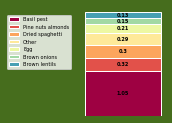

In [374]:
waffleplot(df)

In [382]:
import altair as alt
from vega_datasets import data


In [434]:
alt.Chart(df).configure(background = '#466d1d' ).mark_bar(size = 60).encode(
    alt.Y('sum(impact)', axis = None),
    color = alt.Color('impact', scale=alt.Scale(scheme='greens'), legend=alt.Legend(title="Impact per Ingredient", orient = 'left'))
).configure_view(strokeOpacity=0)




alt.Chart(...)

In [390]:
source = data.barley()

alt.Chart(source).mark_bar().encode(
    y='sum(yield)',
    color='site'
)

alt.Chart(...)